In [1]:
import os
from graspy.utils import augment_diagonal,binarize,pass_to_ranks,remove_loops,to_laplace
from graspy.cluster import GaussianCluster, KMeansCluster
from graspy.embed import selectSVD

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import community as community
from collections import Counter

from src.cluster import BinaryCluster
from src.data import load_metagraph
from src.graph import MetaGraph
from src.hierarchy import signal_flow
from src.io import savecsv, savefig
from src.utils import get_paired_inds
from src.hierarchy import signal_flow
from src.visualization import CLASS_COLOR_DICT
np.random.seed(8888)

#from karateclub import EgoNetSplitter
#sns.set_style("white")
sns.color_palette("deep")
sns.set_context("talk", font_scale=1)

In [2]:
os.chdir('/Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_repo')

graph_type = "Gad"
master_mg = load_metagraph(graph_type)
mg = master_mg.remove_pdiff()
meta = mg.meta

degrees = mg.calculate_degrees()
quant_val = np.quantile(degrees["Total edgesum"], 0.05)
idx = meta[degrees["Total edgesum"] > quant_val].index
print(quant_val)
mg = mg.reindex(idx, use_ids=True)

idx = mg.meta[mg.meta["hemisphere"].isin(["L", "R"])].index
mg = mg.reindex(idx, use_ids=True)

idx = mg.meta[mg.meta["pair"].isin(mg.meta.index)].index
mg = mg.reindex(idx, use_ids=True)

mg = mg.make_lcc()
mg.calculate_degrees(inplace=True)

meta = mg.meta
meta["pair_td"] = meta["pair_id"].map(meta.groupby("pair_id")["Total degree"].mean())
mg = mg.sort_values(["pair_td", "pair_id"], ascending=False)
meta["inds"] = range(len(meta))
adj = mg.adj.copy()
lp_inds, rp_inds = get_paired_inds(meta)
left_inds = meta[meta["left"]]["inds"]

print(f"Neurons left after preprocessing: {len(mg)}")

1.0
Neurons left after preprocessing: 2321


In [3]:
G = nx.to_networkx_graph(adj)
L = nx.line_graph(G)
adj_L = nx.adjacency_matrix(L).toarray()

In [31]:
len(adj_L)

50170

(array([  505.,  4549., 11267., 13300., 10515.,  6209.,  2712.,   887.,
          197.,    29.]),
 array([  3. ,  33.1,  63.2,  93.3, 123.4, 153.5, 183.6, 213.7, 243.8,
        273.9, 304. ]),
 <a list of 10 Patch objects>)

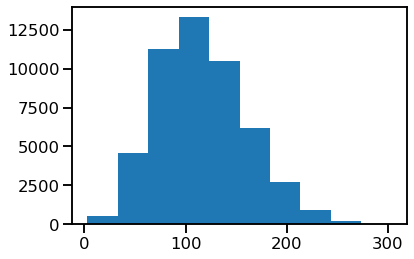

In [9]:
d = [np.sum(adj_L[i,:]) for i in range(len(adj_L))]
plt.hist(d)

In [9]:
# check whether the graph is sparse

adj_L_size = adj_L.size
(adj_L_size - np.count_nonzero(adj_L)) > (adj_L_size / 2)

True

In [6]:
adj_L = adj_L.astype('f')

In [7]:
svd_embed = selectSVD(adj_L, n_components=16, algorithm="truncated")[0]

In [69]:
# hierachical clustering

# min_clus = 2
# max_clus = 10
# clus = []
# for k in range(min_clus, max_clus): 
#     GMM = GaussianCluster(min_components=k, max_components=k, covariance_type="all")
#     clus.append(GMM.fit_predict(svd_embed))

In [71]:
max_clus = 10
GMM = GaussianCluster(min_components=2, max_components=max_clus, covariance_type="all", n_init=10)
clus = GMM.fit_predict(svd_embed)

In [145]:
edge_list = pd.DataFrame(L)
# for i in range(len(edge_list)):
#     for j in range(0,2):
#         edge_list[j].iloc[i] = meta.index.values[edge_list[j].iloc[i]]

In [26]:
connector_path = "maggot_models/data/processed/2020-05-08/connectors.csv"
connectors = pd.read_csv(connector_path)

In [298]:
#for i in range(max(clus)):
i = 1
in_clus = np.asarray(np.where(clus==i)).reshape(-1,1)
print(len(in_clus))
nodes = np.zeros((len(in_clus),2))
for j in range(len(in_clus)):
    nodes[j,:] = [edge_list[0].iloc[in_clus[j]], edge_list[1].iloc[in_clus[j]]]
nodes = nodes.astype(int)

1031


In [299]:
classes = np.unique(meta["class1"])
class_nodes = np.zeros((len(nodes), 2))
for i in range(len(class_nodes)):
    for j in range(0,2):
        class_nodes[i,j] = np.asarray(np.where(classes == meta["class1"].iloc[nodes[i,j]]))[0][0]

In [300]:
a = pd.DataFrame(class_nodes)
for i in range(len(class_nodes)):
    for j in range(0,2):
        a.iloc[i,j] = classes[class_nodes[i,j].astype(int)]

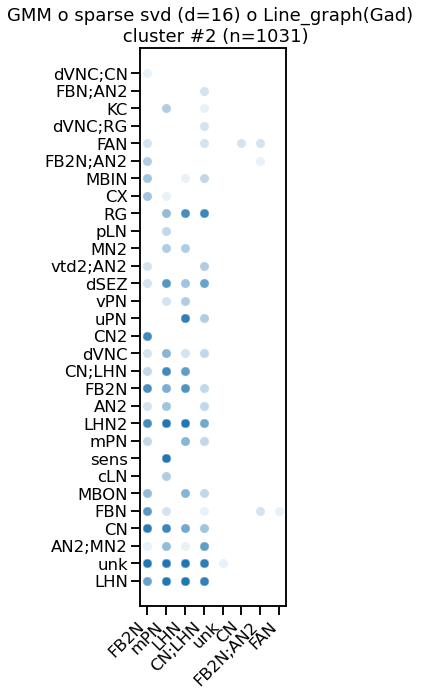

In [303]:
Fig = plt.figure(figsize=(5,10))
fig = sns.scatterplot(data = a, x = 0, y = 1, alpha = 0.1)
plt.xticks(rotation = 45, horizontalalignment='right')
fig.set(xlabel="", ylabel = "", title = "GMM o sparse svd (d=16) o Line_graph(Gad) \n cluster #2 (n=%i)" %len(in_clus))
Fig.subplots_adjust(left=0.2)
Fig.tight_layout()
plt.savefig('clus_2')